In [323]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import imageio
from PIL import Image, ImageDraw, ImageFont


import pydicom
from pathlib import Path
import cv2
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tensorboard.backend.event_processing import event_accumulator
from pytorch_lightning.callbacks import EarlyStopping


import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox

# Data Preprocessing

In [145]:
labels_path = Path('Data/rsna_heart_detection.csv')
Root_path = Path('Data/stage_2_train_images/')
Save_path = Path('Data/Processed')
images_path = Path('images/')
os.makedirs(images_path, exist_ok=True)

In [149]:
labels = pd.read_csv(labels_path)
labels.head(10)

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224
5,heart,63,60,100,85,f1e96436-85c2-4179-b7e9-3f3091e29d76,224,224
6,heart,102,87,60,61,a20a3112-7585-430c-b648-8d81d301acbf,224,224
7,heart,85,71,77,77,eb31f994-518b-4e9d-9a52-ccbf541cfa9f,224,224
8,heart,89,65,71,85,4cf82164-6678-4864-bbc4-5a93419424f7,224,224
9,heart,84,65,76,72,e20af8e8-56f2-486f-962e-7706d77dc5f5,224,224


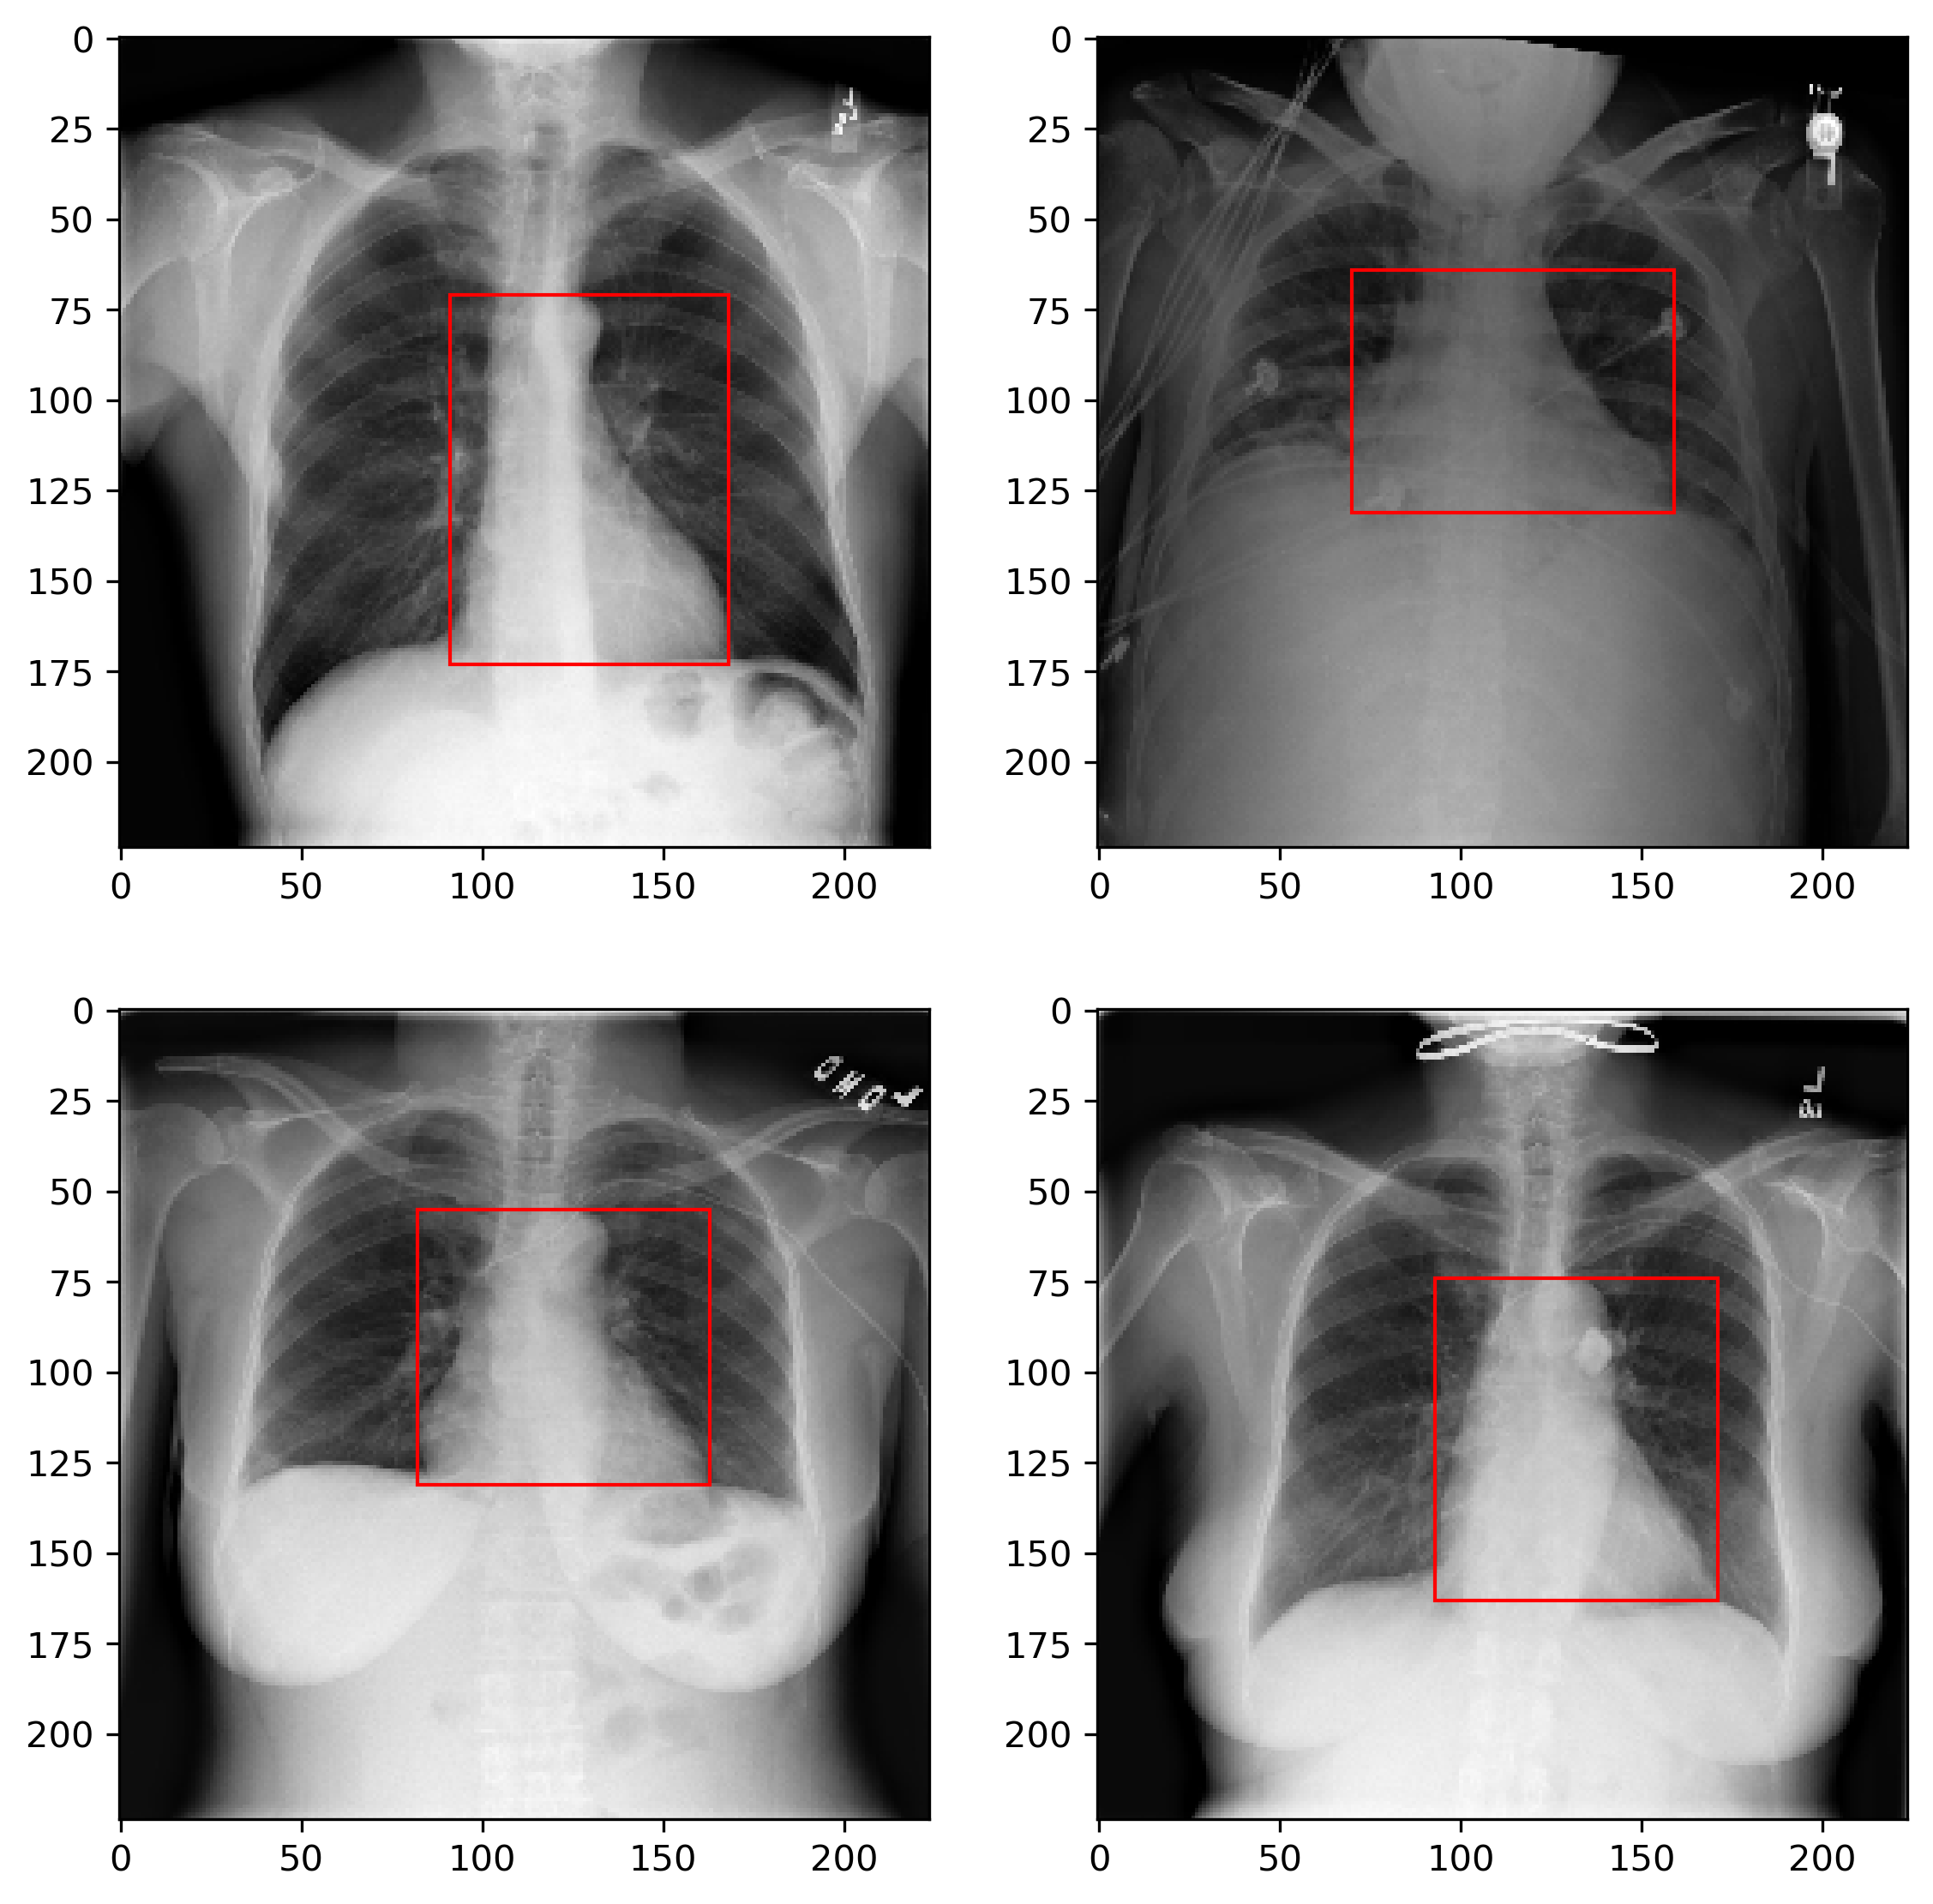

In [151]:
fig , ax = plt.subplots(2,2, figsize = (9,9),dpi = 300)

c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        dcm_path = (Root_path/str(data['name']))
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.dcmread(dcm_path).pixel_array
        dcm = cv2.resize(dcm, (224, 224))

        x = data['x0']
        y = data['y0']
        h = data['h']
        w = data['w']
        
        ax[i][j].imshow(dcm, cmap = 'gray')
        rect = patches.Rectangle((x,y), w, h, edgecolor = 'red' , linewidth = 1, facecolor = 'none')
        ax[i][j].add_patch(rect)
        c += 1
plt.savefig(images_path/'sample_cardiac.png')

## Normalization

In [153]:
sum = 0
sum_squared = 0

train_ids = []
val_ids = []

for counter , patient_id in tqdm(enumerate(labels['name'])):
    dcm_path = (Root_path/str(patient_id))
    dcm_path = dcm_path.with_suffix('.dcm')
    dcm = pydicom.dcmread(dcm_path).pixel_array
    dcm = (cv2.resize(dcm, (224, 224))/255).astype(np.float16)

    
    train_or_val = 'train' if counter < 400 else 'validation'

    if train_or_val == 'train':
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)
        
    current_save_path = Save_path/train_or_val
    current_save_path.mkdir(parents = True, exist_ok=True)

    np.save(current_save_path/patient_id, dcm)

    normalizer = 224 * 224
    if train_or_val == 'train':
        sum += np.sum(dcm)/normalizer
        sum_squared += (dcm**2).sum()/normalizer



0it [00:00, ?it/s]

In [154]:
mean = sum / len(train_ids)

std = np.sqrt(sum_squared/len(train_ids) - mean**2)
print(f'Mean: {mean}, std: {std}')

Mean: 0.4947441007653059, std: 0.252830907285576


In [157]:
np.save(Save_path/'train_subjects',train_ids)
np.save(Save_path/'val_subjects',val_ids)

## Data Augmentation
We need to make sure to apply the changes on image and the bounding box.

In [260]:
class cardiac_Dataset(torch.utils.data.Dataset):

    def __init__(self,path_to_labels,root_path , aug, patients , mean, std):
        
        self.labels = pd.read_csv(path_to_labels)
        self.root_path = Path(root_path)
        self.patients = np.load(patients)
        self.augment = aug
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.patients)

    def __getitem__(self,idx):
        patient = self.patients[idx]
        data = self.labels[self.labels['name'] == patient]

        file_path = self.root_path/patient
        img = np.load(f"{file_path}.npy").astype(np.float32)

        ## bounding box
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()
        y_max = y_min + data["h"].item()
        bbox = [x_min , y_min , x_max , y_max]

        if self.augment :
            bb = BoundingBox(x1 = bbox[0] , y1 = bbox[1] , x2 = bbox[2] , y2 = bbox[3])
            random_seed = torch.randint(0,100000, (1,)).item()
            imgaug.seed(random_seed)

            img , aug_bbox = self.augment(image = img , bounding_boxes = bb)
            bbox = aug_bbox[0][0] , aug_bbox[0][1] , aug_bbox[1][0] , aug_bbox[1][1]

        ## normalization
        img = (img - self.mean) / self.std
        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
        
        return img, bbox
        

In [262]:
seq = iaa.Sequential([
                    iaa.GammaContrast(),
                    iaa.Affine(scale = (0.8,1.2) , rotate = (-10, 10) , translate_px = (-10, 10))
                    ])

In [264]:
dataset = cardiac_Dataset(path_to_labels = labels_path ,root_path = Save_path/'train/', aug = seq, patients = Save_path/'train_subjects.npy' , mean = mean, std = std)


In [268]:
img , bbox = dataset[0]
img.shape

torch.Size([1, 224, 224])

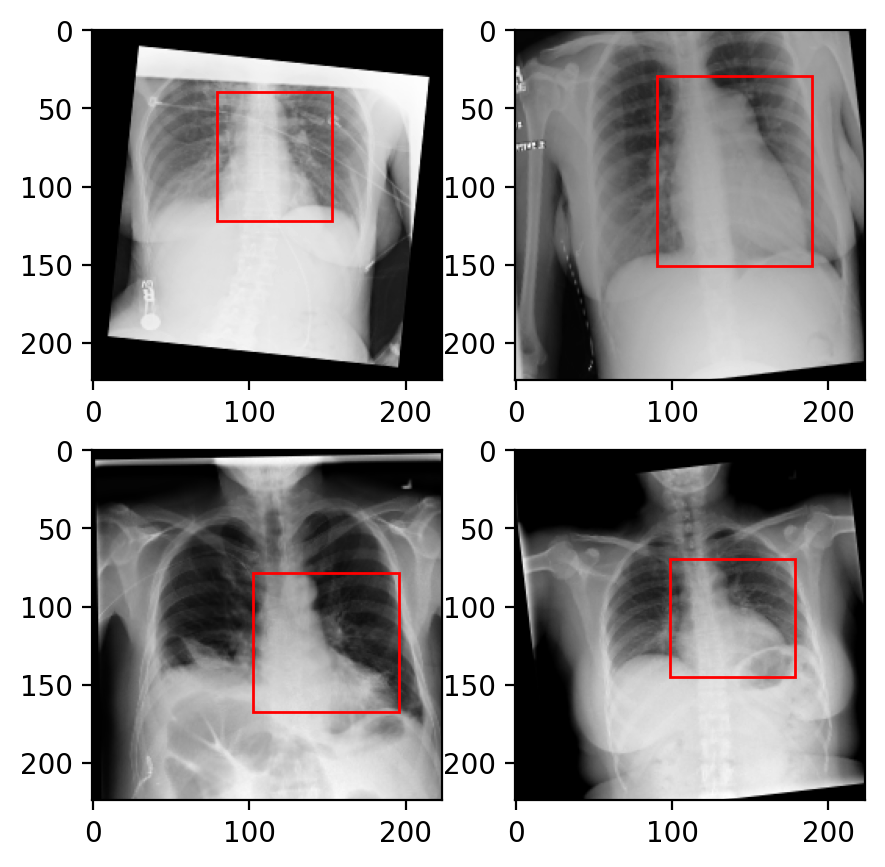

In [284]:
fig , ax = plt.subplots(2,2 , figsize = (5,5) , dpi = 200)

for i in range(2):
    for j in range(2):
        img , bbox = dataset[np.random.randint(0,400)]
        ax[i][j].imshow(img[0] ,cmap = 'gray')
        rect = patches.Rectangle((bbox[0],bbox[1]),(bbox[2]-bbox[0]),(bbox[3]-bbox[1]), edgecolor = 'red' ,facecolor = 'none', linewidth = 1)
        ax[i][j].add_patch(rect )

plt.savefig(images_path/"cardiac_augmented_sample.png")

## Loading Datasets

In [286]:
train_path = Save_path/"train/"
train_subjects_path = Save_path/'train_subjects.npy'
val_path = Save_path/"validation/"
val_subjects_path = Save_path/'val_subjects.npy'

In [292]:
train_transform = iaa.Sequential([iaa.GammaContrast(),
                                  iaa.Affine(scale = (0.8 , 1.2) , rotate = (-10 , 10) , translate_px = (-10 , 10))])
train_dataset = cardiac_Dataset(path_to_labels = labels_path ,root_path = train_path, aug = train_transform, patients = train_subjects_path , mean = mean, std = std)
test_dataset = cardiac_Dataset(path_to_labels = labels_path ,root_path = val_path, aug = None, patients = val_subjects_path , mean = mean, std = std)


In [294]:
batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size , num_workers = num_workers , shuffle = True)

test_loader = torch.utils.data.DataLoader(test_dataset , batch_size = batch_size , num_workers = num_workers , shuffle = False)

# Model Creation

In [301]:
torchvision.models.resnet18(pretrained = True)

/Users/sima/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sima/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sima/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 30.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [347]:
class CardiaDetectionModel(pl.LightningModule):

    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = torch.nn.MSELoss()

        self.mean = mean
        self.std = std

    def forward(self, data):
        return self.model(data)

    def training_step(self, batch , batch_idx):
        x_ray , label = batch
        label = label.to(x_ray.device).float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        self.log("Train Loss" , loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu() , pred.cpu() , label.cpu() , "Train")
        return loss


    def validation_step(self, batch , batch_idx):
        x_ray , label = batch
        label = label.to(x_ray.device).float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        self.log("Val Loss" , loss)

        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu() , pred.cpu() , label.cpu() , "Val")
        return loss

    def log_images(self , x_ray , pred, label , name):
        results = []
        for i in range(min(4, x_ray.shape[0])):
            img = ((x_ray[i] * self.std) + self.mean).numpy()[0]
            
            coords_labels = label[i]
            coords_pred = pred[i]

            x0,y0 = coords_labels[0].int().item() , coords_labels[1].int().item() 
            x1,y1 = coords_labels[2].int().item() , coords_labels[3].int().item() 
            img =cv2.rectangle(img, (x0,y0), (x1,y1), color = (0,0,0), thickness = 2)

            x0,y0 = coords_pred[0].int().item() , coords_pred[1].int().item() 
            x1,y1 = coords_pred[2].int().item() , coords_pred[3].int().item() 
            img =cv2.rectangle(img, (x0,y0), (x1,y1), color = (1,1,1), thickness = 2)

            results.append(torch.tensor(img).unsqueeze(0))

        grid = torchvision.utils.make_grid(results, 2)
        
        self.logger.experiment.add_image(name, grid, self.global_step)
            

    def configure_optimizers(self):
            return [self.optimizer]

In [349]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CardiaDetectionModel().to(device)

In [351]:
checkpoint_callback = ModelCheckpoint(  monitor = "Val Loss",
                                        save_top_k = 10,
                                        mode = "min"
                                     )

early_stop = EarlyStopping( monitor="Val Loss",       
                            patience=20,               
                            mode="min"
                            )

trainer = pl.Trainer( devices = 1,
                    accelerator = 'mps',
                     logger = TensorBoardLogger("./logs"),
                     log_every_n_steps = 1,
                     callbacks = [checkpoint_callback, early_stop],
                     max_epochs = 100
                    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [353]:
trainer.fit(model , train_loader, test_loader)


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | ResNet  | 11.2 M | train
1 | loss_fn | MSELoss | 0      | train
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/sima/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sima/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


# Model Evaluation

In [356]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [512]:
model = CardiaDetectionModel.load_from_checkpoint("logs/lightning_logs/version_2/checkpoints/epoch=98-step=4950.ckpt")
model.eval()
model.to(device);

In [514]:
preds = []
labels = []

with torch.no_grad():
    for data, label in test_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)

preds = torch.stack(preds)
labels = torch.stack(labels)

In [516]:
abs(preds - labels).mean(0)

tensor([5.5379, 6.0611, 4.7654, 4.6303])

## Sample of predictions of the model

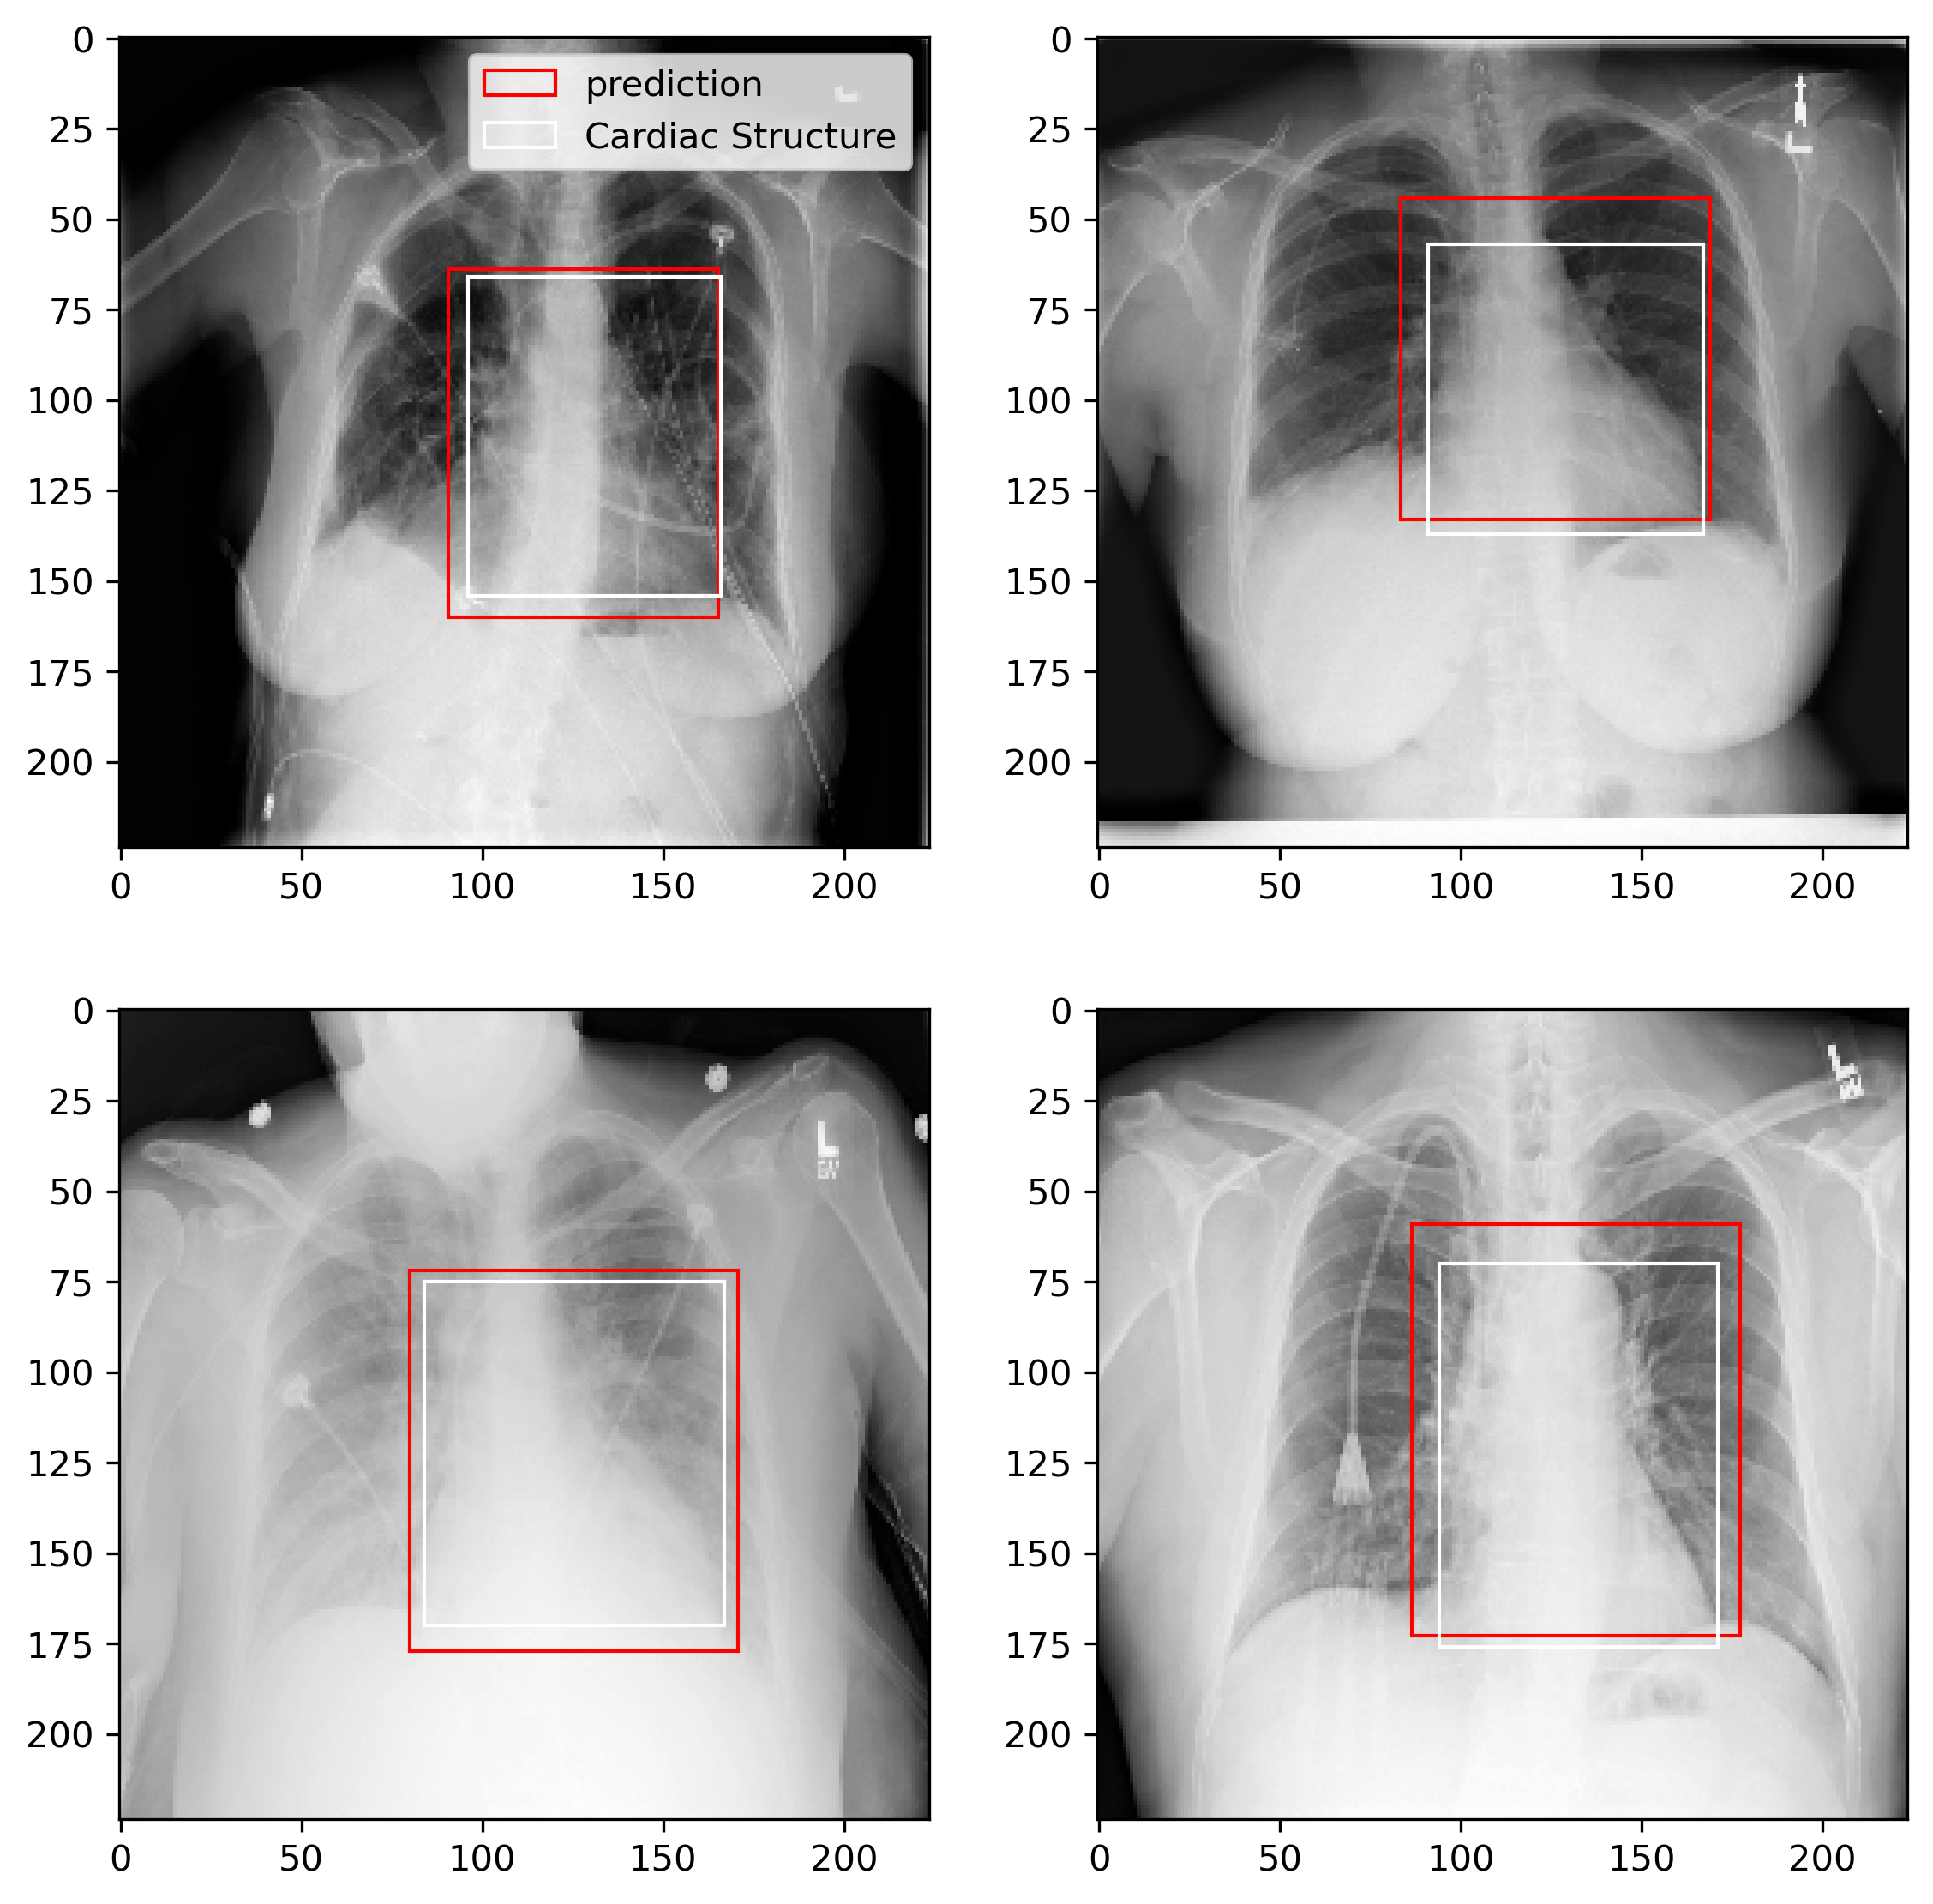

In [519]:
fig , ax = plt.subplots(2,2 , figsize = (9,9) , dpi = 300)
IDX = 0
for i in range(2):
    for j in range(2):
        img, label = test_dataset[IDX]

        ax[i][j].imshow(img[0].cpu(), cmap = 'gray')
        
        predicted_rect = patches.Rectangle((preds[IDX][0], preds[IDX][1]), (preds[IDX][2]- preds[IDX][0]), (preds[IDX][3]-preds[IDX][1]), edgecolor = 'red' , linewidth = 1 ,facecolor = 'none', label ='prediction')
        ax[i][j].add_patch(predicted_rect)
        
        true_rect = patches.Rectangle((label[0], label[1]), (label[2]- label[0]), (label[3]-label[1]), edgecolor = 'white' , linewidth = 1 ,facecolor = 'none' , label = 'Cardiac Structure')
        ax[i][j].add_patch(true_rect)
        

        IDX += 1

ax[0][0].legend()
plt.savefig(images_path/"cardiac_prediction.png")

## Train vs. Validation Loss 

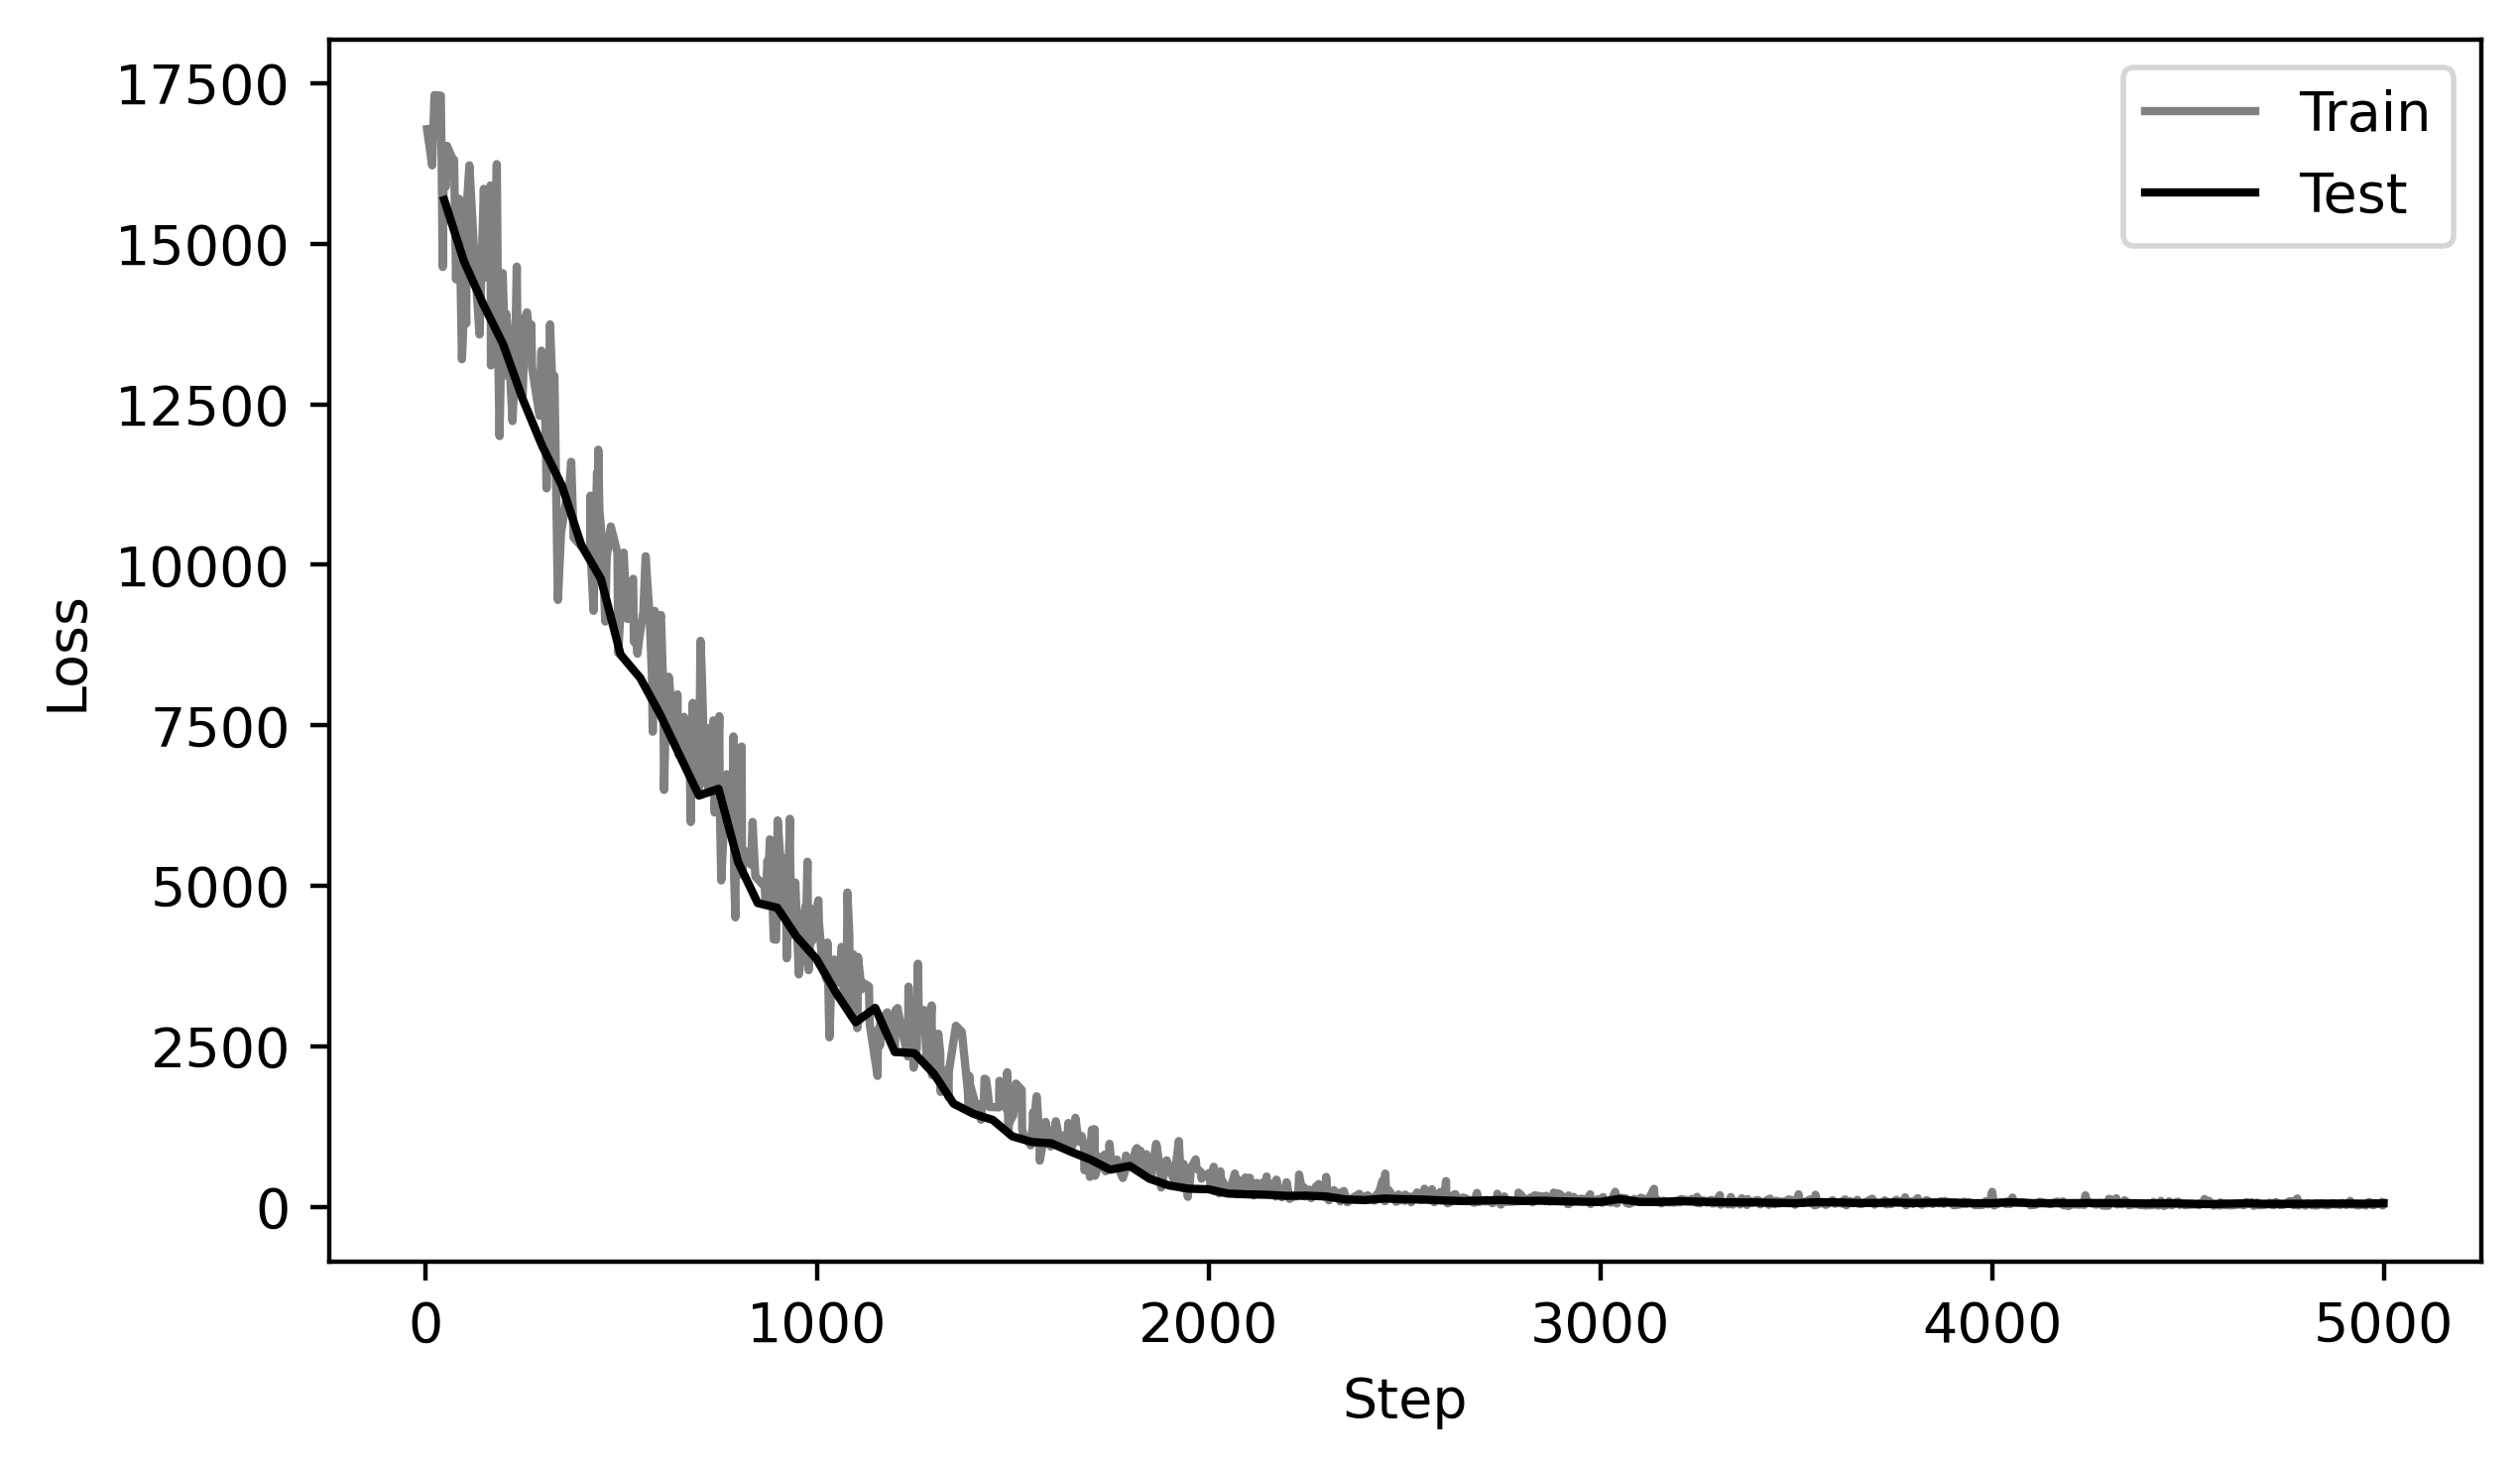

In [522]:
train_loss = pd.read_csv("lightning_logs_train_loss.csv")
test_loss = pd.read_csv("lightning_logs_test_loss.csv")

fig, ax = plt.subplots(1,figsize = (7,4), dpi = 400)
ax.plot(train_loss["Step"],train_loss["Value"] , label = 'Train' , color = 'gray')
ax.plot(test_loss["Step"],test_loss["Value"] , label = 'Test' , color = 'black')
ax.set_ylabel('Loss')
ax.set_xlabel('Step')
ax.legend()

fig.savefig(images_path/'cardiac_detection_loss.png')


## Learning process gif

In [525]:
log_dir = "logs/lightning_logs/version_2"
ea = event_accumulator.EventAccumulator(log_dir, size_guidance={'images': 100})
ea.Reload()

tag = "Val" 
events = ea.Images(tag)

os.makedirs("frames", exist_ok=True)
frames = []

for i, e in enumerate(events):
    filename = f"frames/frame_{i:03d}.png"
    with open(filename, "wb") as f:
        f.write(e.encoded_image_string)

    img = Image.open(filename).convert("RGB")
    draw = ImageDraw.Draw(img)

    draw.text((10, 10), f"Epoch {i}", fill=(255, 255, 255))

    img.save(filename)
    frames.append(imageio.imread(filename))

imageio.mimsave("bbox_progression.gif", frames[::3], duration=0.05)

/var/folders/rj/mk57hg8s74l0y1xwws2ss9k40000gn/T/ipykernel_64130/588055243.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))
